<a href="https://colab.research.google.com/github/bostankhan6/Image-Segmentation-Unet-DeepLabV3-Segnet/blob/master/DeepLab_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Defining the model

In [0]:
%tensorflow_version 2.x
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm_notebook, tnrange
from skimage.transform import resize
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os

import tensorflow as tf

from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras.layers import Add
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import DepthwiseConv2D
from tensorflow.python.keras.layers import ZeroPadding2D
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input

WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1].value  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(tf.nn.relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(tf.nn.relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
    """ Instantiates the Deeplabv3+ architecture
    Optionally loads weights pre-trained
    on PASCAL VOC or Cityscapes. This model is available for TensorFlow only.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images. None is allowed as shape/width
        classes: number of desired classes. PASCAL VOC has 21 classes, Cityscapes has 19 classes.
            If number of classes not aligned with the weights used, last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone. Pretrained is only available for alpha=1.
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same',
                   use_bias=False, name='Conv')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(tf.nn.relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation(tf.nn.relu)(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = Lambda(lambda x: tf.compat.v1.image.resize(x, size_before[1:3],
                                                    method='bilinear', align_corners=True))(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation(tf.nn.relu, name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation(tf.nn.relu)(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        size_before2 = tf.keras.backend.int_shape(x)
        x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
                                                        skip1.shape[1:3],
                                                        method='bilinear', align_corners=True))(x)

        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation(tf.nn.relu)(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if (weights == 'pascal_voc' and classes == 21) or (weights == 'cityscapes' and classes == 19):
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
                                                    size_before3[1:3],
                                                    method='bilinear', align_corners=True))(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    if activation in {'softmax', 'sigmoid'}:
        x = tf.keras.layers.Activation(activation)(x)

    model = Model(inputs, x, name='deeplabv3plus')

    return model

In [0]:
!cp -r /content/drive/My\ Drive/A3-Datasets/MonuSeg /content

## Setting Parameters and Loading Data

In [0]:
"""
Used to patchify the dataset of Semantic Segmentation
Set the directory for the current dataset, be sure to change the parameters.
Give new Dataset Dir, also specify the sub directories.
Patch size and Stride can be changed.
"""
import os
from skimage.io import imread, imsave
from skimage.util.shape import view_as_windows

# Parameters to change.
curr_dataset_dir = "MonuSeg/"
new_dataset_dir = "patched_MonuSeg/"

sub_dirs = ["Training/TissueImages/", "Training/GroundTruth/",
             "Test/TissueImages/", "Test/GroundTruth/"]
patch_size = {'rgb': (256,256, 3), 'grayscale': (256,256)}
stride = {'rgb': (256//2, 256//2, 3), 'grayscale': (256//2, 256//2)}

# Create the new dataset directory
os.makedirs(new_dataset_dir, exist_ok=True)

for sub_dir in sub_dirs:
    new_dir_ = new_dataset_dir + sub_dir
    # Create sub_dir in the new dataset directory
    os.makedirs(new_dir_, exist_ok=True)
    dir_ = curr_dataset_dir + sub_dir
    ids = next(os.walk(dir_))[2]

    for id_ in ids:
        img = imread(dir_ + id_)
        img_type = 'rgb' if img.ndim == 3 else 'grayscale'
        new_imgs = view_as_windows(img, patch_size[img_type], stride[img_type])
        new_imgs = new_imgs.reshape(-1, 256, 256, 3) if img.ndim == 3 else new_imgs.reshape(-1, 256, 256)
        for i, patch in enumerate(new_imgs):
            file_name, extension = id_.split('.')
            new_file_name = file_name + f'-PCH{i}.' + extension
            imsave(new_dir_ + new_file_name, patch)

In [0]:
"""
This function can be used to read the images from the dataset created by the patchify_dataset.py.
Example Usage:
X, y = get_images("ModMonuSeg/Training/", (im_width, im_height))
"""
def get_images(parent_dir, im_shape, img_folder="TissueImages/", gt_folder="GroundTruth/", gt_extension=None):
  tissue_dir = parent_dir + img_folder
  gt_dir = parent_dir + gt_folder

  im_width, im_height = im_shape


  ids = next(os.walk(tissue_dir))[2]
  print("No. of images = ", len(ids))

  X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
  y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

  # tqdm is used to display the progress bar
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(tissue_dir+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 3), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0]
    mask_id_ = '-'.join(id_.split('-')[:-1]) + '_bin_mask-'+ id_.split('-')[-1]
    if gt_extension:
      mask_id_ = mask_id_.split('.')[0] + '.' + gt_extension
    mask = img_to_array(load_img(gt_dir+mask_id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

  return X, y

In [0]:
train_parent_dir = '/content/patched_MonuSeg/Training/'
val_parent_dir = '/content/patched_MonuSeg/Test/'
im_shape = (256,256)
X_train, y_train = get_images(train_parent_dir, im_shape)


No. of images =  1080


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
X_test, y_test = get_images(val_parent_dir, im_shape, gt_extension='png')

No. of images =  504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


#### Below code can be used to visualize the images and corresponding masks

Training Set Image

Text(0.5, 1.0, 'Ground Truth')

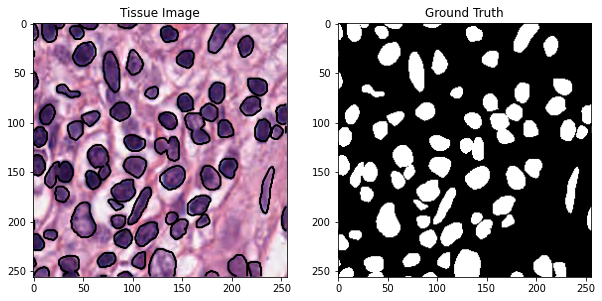

In [0]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))

ax1.imshow(X_train[ix])
if has_mask:
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 2, levels = [0.5])

ax1.set_title('Tissue Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Ground Truth')

# Define the parametric functions



In [0]:
def dice_coef(y_true, y_pred):
  intersection = K.sum(y_true * y_pred, axis = (1,2,3))
  union = K.sum(y_true, axis = (1,2,3)) + K.sum(y_pred, axis = (1,2,3))
  return K.mean((2.0*intersection+1)/(union+1),axis = 0) 

In [0]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Getting the model and compiling

In [0]:
model = Deeplabv3(weights=None, input_shape=(256, 256, 3), classes=1, backbone='xception',
              OS=16, activation='sigmoid')
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy",dice_coef,f1_m])
#model.summary()

In [0]:
# Define the callbacks

callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=6, min_lr=0.000001, verbose=1),
    ModelCheckpoint('improved_unet_model.h5', verbose=1, save_weights_only=True, save_best_only=True, monitor='val_accuracy')
]

# Training the Model

In [0]:
results = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_split= 0.1
                    ,callbacks=callbacks)

Epoch 1/100
61/61 [==============================] - 38s 630ms/step - loss: 0.3732 - accuracy: 0.8270 - dice_coef: 0.5562 - f1_m: 0.6502 - val_loss: 0.5839 - val_accuracy: 0.7353 - val_dice_coef: 0.2796 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 2/100
61/61 [==============================] - 36s 582ms/step - loss: 0.2832 - accuracy: 0.8751 - dice_coef: 0.6655 - f1_m: 0.7678 - val_loss: 0.5882 - val_accuracy: 0.7353 - val_dice_coef: 0.2184 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 3/100
61/61 [==============================] - 35s 581ms/step - loss: 0.2656 - accuracy: 0.8836 - dice_coef: 0.6868 - f1_m: 0.7850 - val_loss: 0.6345 - val_accuracy: 0.7353 - val_dice_coef: 0.1718 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 4/100
61/61 [==============================] - 35s 580ms/step - loss: 0.2526 - accuracy: 0.8902 - dice_coef: 0.7027 - f1_m: 0.7969 - val_loss: 0.7109 - val_accuracy: 0.7353 - val_dice_coef: 0.1261 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 5/100
61/61 [=========================

Saving the model and history files to drive

In [0]:
!cp /content/improved_unet_model.h5 /content/drive/My\ Drive/Models/ACV\ A3\ Models/Improved

In [0]:
import pickle
with open('/content/drive/My Drive/Models/ACV A3 Models/Improved/improved_deeplab3_weights', 'wb') as file_pi:
        pickle.dump(model.weights, file_pi)

# Plotting the Graphs

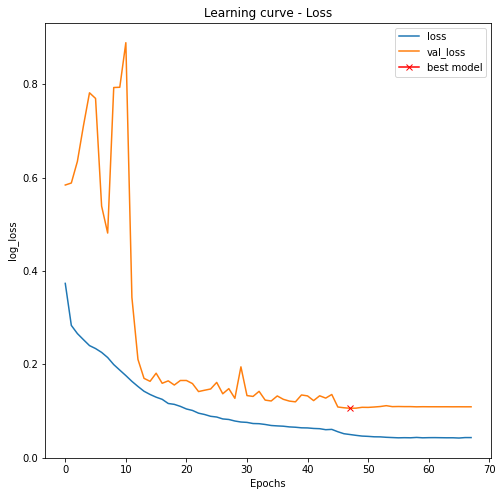

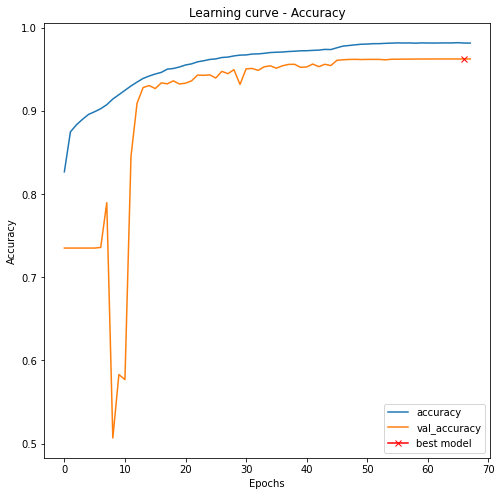

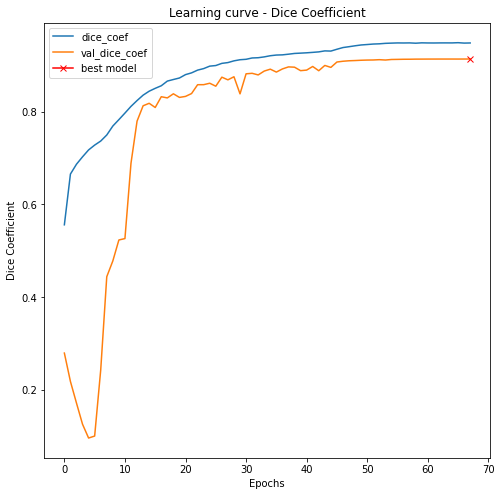

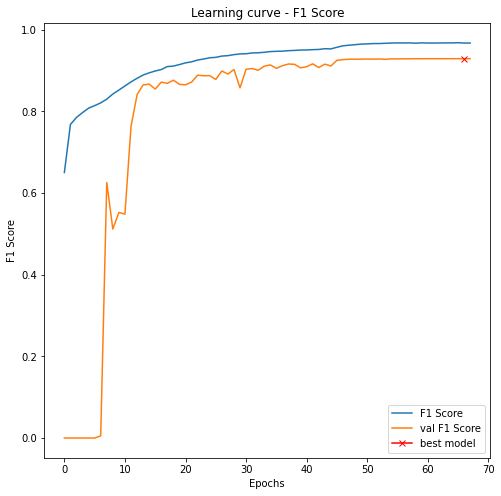

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - Loss")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve - Accuracy")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve - Dice Coefficient")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve - F1 Score")
plt.plot(results.history["f1_m"], label="F1 Score")
plt.plot(results.history["val_f1_m"], label="val F1 Score")
plt.plot( np.argmax(results.history["val_f1_m"]), np.max(results.history["val_f1_m"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend();

### Inference

In [0]:
# save the best model
model.save('/content/drive/My Drive/Models/ACV A3 Models/improved_deeplab3_model.h5')

In [0]:
# Evaluate on test set
model.evaluate(X_test, y_test, verbose=1)

16/16 [==============================] - 4s 279ms/step - loss: 0.4292 - accuracy: 0.9059 - dice_coef: 0.7589 - f1_m: 0.7766


[0.4292416274547577, 0.9059018492698669, 0.758868396282196, 0.7766264081001282]

In [0]:
# Predict on train, val and test
preds_train = model.predict(X_train, batch_size = 1, verbose=1)
preds_val = model.predict(X_test, batch_size = 1, verbose=1)

504/504 [==============================] - 10s 20ms/step


In [0]:
# Out Thresholds on the the prediction to get either 1 or 0
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)

Helper function for plotting the predictions

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
  #Arguments:
  #X: Train Set
  #y: ground truth Masks
  #preds: the predicted masks
  #binary_preds: the predicted masks after thresholding to 0 or 1
  #ix: if None, it will take a random sample. If provided with the index of the 
  #sample, it will plot that specific sample from tissue images
  
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X)-1)

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

### Visual predictions on training set

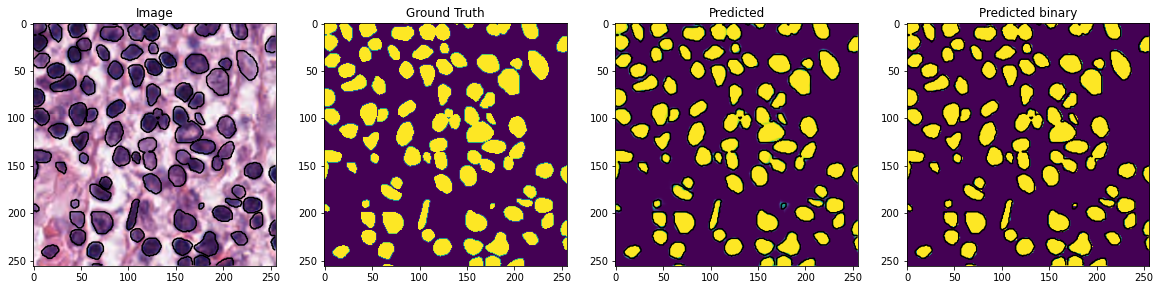

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

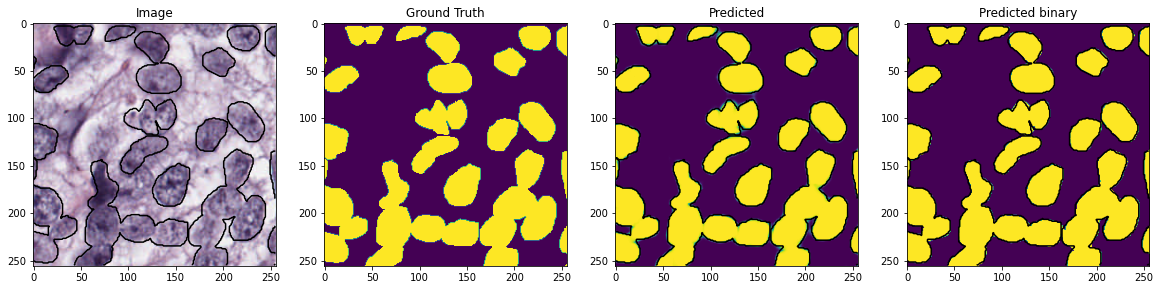

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

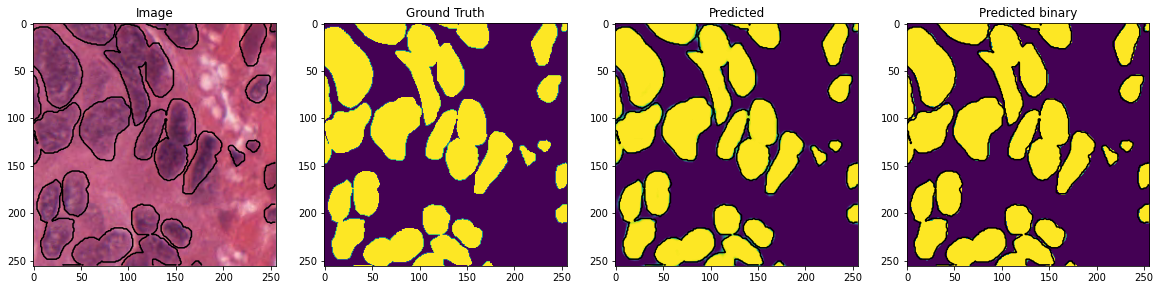

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Visual Predictions on test set

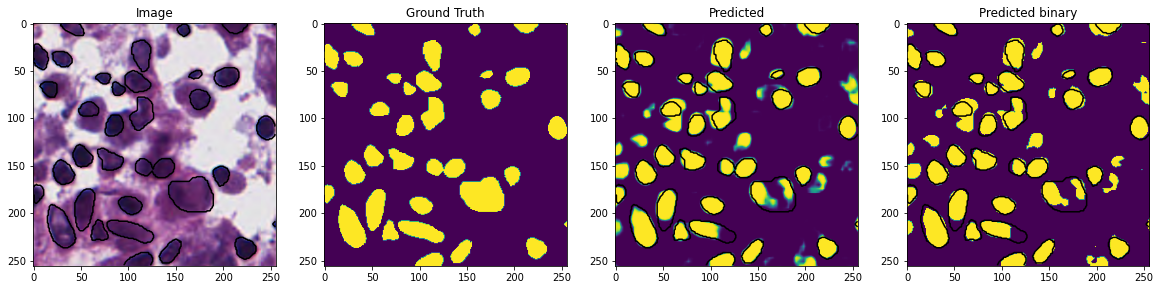

In [0]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

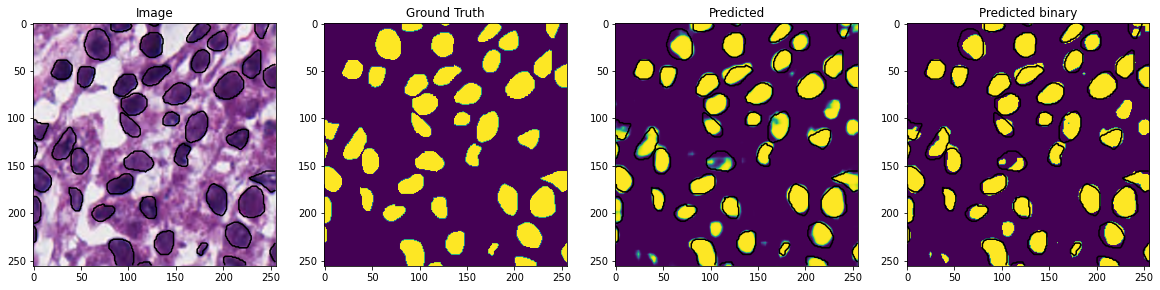

In [0]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

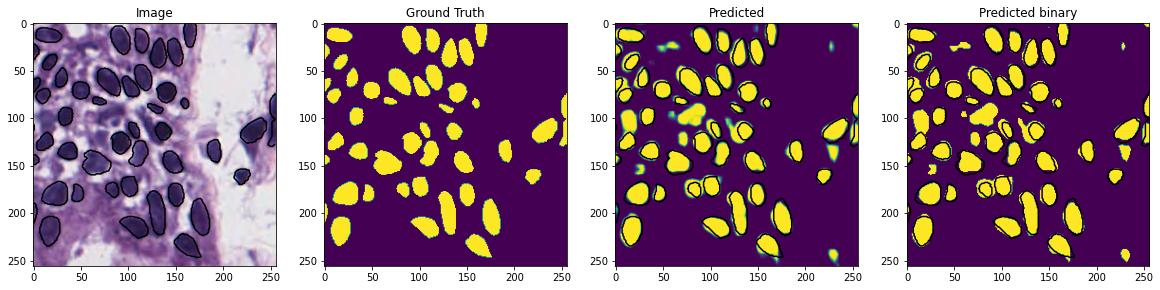

In [0]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

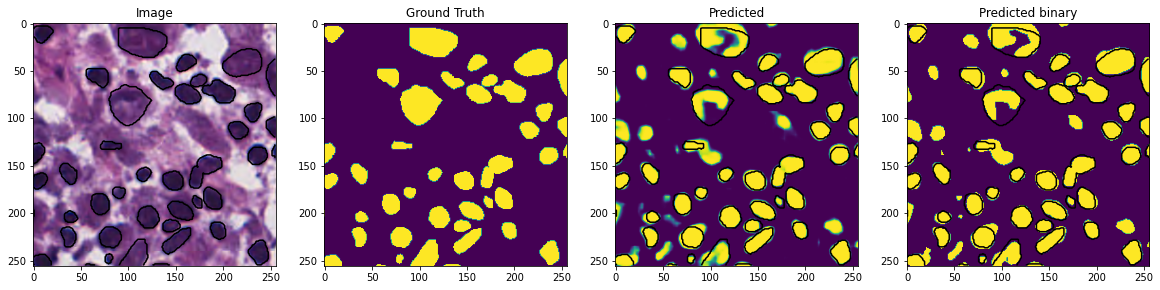

In [0]:
plot_sample(X_test, y_test, preds_val, preds_val_t)